# <center>SFML/INFO-F422: Statistical foundations of machine learning</center>

# <center>Classification Project</center>

Name: Mathieu Parmentier & Nilson Toula

Python version: 3.6

Date: XXXXX


# Objective and strategy 

## Material and method

### Boston home data set: (pour le lire, il ne faut pas faire tourner le data set synthetique)

In [28]:
import pandas as pd
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

data = datasets.load_boston()
X = np.array(data.data)
Y = np.array(data.target)
label =data.feature_names

# Pour deux catégorie: 0 ou 1
Y = Y < 22 

Exploration of the data

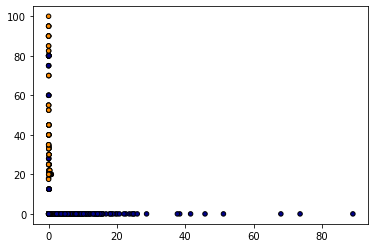

In [13]:
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])


# Plot all the data
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap_bold,edgecolor='k', s=20)


plt.show()

### Synthetic data set:

In [9]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import numpy as np

# flip_y: put some noise in the function
X, Y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2,n_clusters_per_class=1,n_classes=2, flip_y=.1)
# function of type: z = f(x,y)

Exploration of the synthetic data

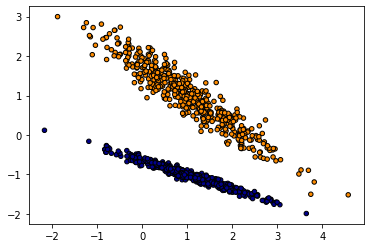

In [10]:
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])


# Plot all the data
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap_bold,edgecolor='k', s=20)
#plt.xlim(0, 50)
#plt.ylim(0, 40)

plt.show()

Building of the training set and test set

In [3]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = .2, random_state = 25)

### 1) Algorithm: Gaussian Naive Bayes

#### a) Introduction
     Theorical approach
Let $ \{(x_n, y_n) : x_n \in \mathbb{R}^d, y_n \in \{-1;1\} \} $ be the training set, $n= 1,\dots, N$ . 
The hypothesis space  of the Gaussian Naive Bayes or GNB is: 
   $$\mathcal{H}_{GNB} = \{ h \in \mathcal{H} : h(x) = P(y_n \mid x_n) \}$$
   
   Where $P(y_n \mid x_n)$ is the posterior probability of the well known Bayes Formula:
    
$$P(y \mid x) = \frac{P(y) P(x \mid y)}{P(x)}$$



In this algorithme we assume that the values associated with each class are distributed according to a Gaussian (also called Normal) law:
       $$P(x_i \mid y) = \frac{1}{\sqrt{2\pi\sigma^2_y}} \exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma^2_y}\right)$$
   Where $\mu$ is the mean of the distribution, $\sigma$ is the standard deviastion (nb: $\sigma^2$ is the variance of the distribution).       


       Learning phase
In order to compute $P(y_n \mid x_n)$, we need to get the evidence of every data-point $P(x_n)$, for every class $y_n$: the likelihood of the features in those classes: $P(x_{n_i} \mid y_n)$ , and the prior probability: $P(y_n)$.

        Classification phase
For every new point $x_{new}$ , we compute $h(x_{new}) = \operatorname*{arg\,max}_{y_n}( P(y_n \mid x_{new}) )$




     Why do we call it naive?
   This algorithm is said Naive because we assume that our model correctly simulate the real world and that all the attribute is independant (we don't model any of the interelashionship between the attributes).
  But in this case we are not focusing on what is exactly the probability (we said that GNB is a bad estimator) but the order of that probability.
  
  Another issue is when we encounter a new attribute combination we have never seen before, we will have $P(x_i \mid V) = 0$
  Which will compromise our calculations, to counteract that, we will smooth the our probabilities by initialising any probability to a value different than 0. Doing so is admiting that there is an inductive bias in our data which make our algorithm "less naive".
       

code

In [4]:
from sklearn.naive_bayes import GaussianNB

GNB = GaussianNB()
GNB.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

Score

In [5]:
#Computation of E in and E out
E_in_GNB = GNB.score(x_train, y_train)
E_out_GNB = GNB.score(x_test, y_test)

#cross validation of the model with cv = 5
from sklearn.model_selection import cross_val_score
cv_scores_GNB = cross_val_score(GNB, X, Y, cv=5)

#print the cross validation score and average
print("cv_scores_GNB :",cv_scores_GNB)
print("cross validation mean score for GNB :",np.mean(cv_scores_GNB))

cv_scores_GNB : [0.875 0.905 0.87  0.92  0.905]
cross validation mean score for GNB : 0.8949999999999999


Plot of the results

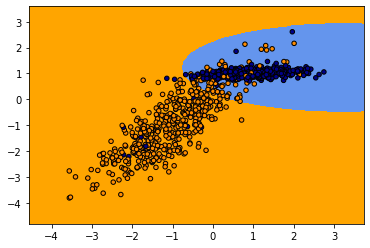

In [27]:
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),np.arange(y_min, y_max, 0.02))
Z = GNB.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap_bold,edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

### 2) Algorithm: Support vector classifier/machine → être plus précis sur l'algo utilisé: NuSVC

code

In [30]:
from sklearn import svm

NuSVC = svm.NuSVC(gamma='auto')
NuSVC.fit(x_train, y_train)

NuSVC(cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

Score

In [8]:
#Computation of E in and E out
E_in_NuSVC = NuSVC.score(x_train, y_train)
E_out_NuSVC = NuSVC.score(x_test, y_test)

#cross validation of the model with cv = 5
from sklearn.model_selection import cross_val_score
cv_scores_NuSVC = cross_val_score(NuSVC, X, Y, cv=5)

#print the cross validation score and average
print("cv_scores_NuSVC :",cv_scores_NuSVC)
print("cross validation mean score for NuSVC :",np.mean(cv_scores_NuSVC))

cv_scores_NuSVC : [0.895 0.92  0.885 0.94  0.905]
cross validation mean score for NuSVC : 0.909


Plot of the results

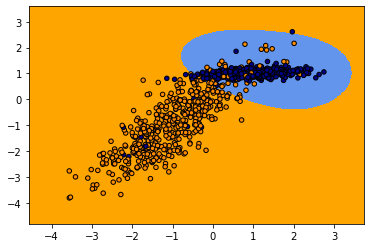

In [31]:
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),np.arange(y_min, y_max, 0.02))
Z = NuSVC.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap_bold,edgecolor='k', s=20)
# plt.xlim(xx.min(), xx.max())
# plt.ylim(yy.min(), yy.max())


plt.show()

### 3) Algorithm: Nearest Neighbors Classification

code

In [20]:
from sklearn import neighbors


n_neighbors = 15
h = .02  # step size in the mesh

NNC_uniform = neighbors.KNeighborsClassifier(n_neighbors, weights= 'uniform')
NNC_distance = neighbors.KNeighborsClassifier(n_neighbors, weights= 'distance')

NNC_uniform.fit(x_train, y_train)
NNC_distance.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='distance')

Score

In [14]:
#Computation of E in and E out
E_in_NNC_uniform = NNC_uniform.score(x_train, y_train)
E_out_NNC_uniform = NNC_uniform.score(x_test, y_test)

E_in_NNC_distance = NNC_distance.score(x_train, y_train)
E_out_NNC_distance = NNC_distance.score(x_test, y_test)

#cross validation of the model with cv = 5
from sklearn.model_selection import cross_val_score
cv_scores_NNC_uniform = cross_val_score(NNC_uniform, X, Y, cv=5)
cv_scores_NNC_distance = cross_val_score(NNC_distance, X, Y, cv=5)

#print the cross validation score and average
print("cv_scores_NNC_uniform :",cv_scores_NNC_uniform)
print("cross validation mean score for NNC_uniform :",np.mean(cv_scores_NNC_uniform))
print("cv_scores_NNC_distance :",cv_scores_NNC_distance)
print("cross validation mean score for NNC_distance :",np.mean(cv_scores_NNC_distance))

cv_scores_NNC_uniform : [0.895 0.94  0.905 0.95  0.91 ]
cross validation mean score for NNC_uniform : 0.9200000000000002
cv_scores_NNC_distance : [0.89  0.935 0.905 0.96  0.91 ]
cross validation mean score for NNC_distance : 0.9200000000000002


Plot of the results

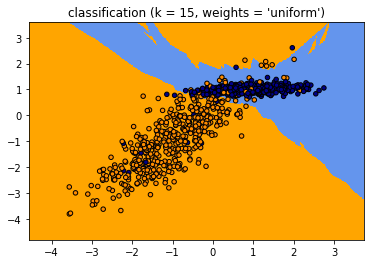

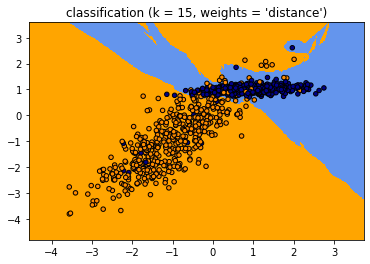

In [15]:
from sklearn import neighbors


n_neighbors = 15


h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(x_train, y_train)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.title("classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

### 4) Algorithm: Random Forest Classifier

code

In [21]:
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier)

RFC = RandomForestClassifier(max_depth=2, random_state=0)
RFC.fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Score

In [17]:
#Computation of E in and E out
E_in_RFC = RFC.score(x_train, y_train)
E_out_RFC = RFC.score(x_test, y_test)

#cross validation of the model with cv = 5
from sklearn.model_selection import cross_val_score
cv_scores_RFC = cross_val_score(RFC, X, Y, cv=5)

#print the cross validation score and average
print("cv_scores_RFC :",cv_scores_RFC)
print("cross validation mean score for RFC :",np.mean(cv_scores_RFC))

cv_scores_RFC : [0.895 0.95  0.905 0.955 0.935]
cross validation mean score for RFC : 0.9280000000000002


Plot of the results

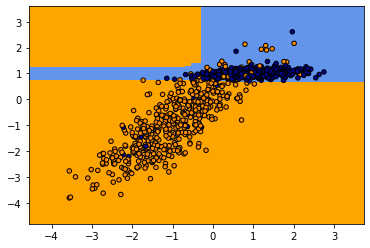

In [18]:
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),np.arange(y_min, y_max, 0.02))
Z = RFC.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap_bold,edgecolor='k', s=20)

plt.show()

### Algorithm 1: Random Forest

In [ ]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn import datasets #import datasets from scikit-learn

In [ ]:
data = datasets.load_boston()

In [ ]:
# define the data/predictors as the pre-set feature names
X = pd.DataFrame(data.data, columns=data.feature_names)

In [ ]:
X.head(6)

In [ ]:
# Put the target (housin value -- MEDV) in another DataFrame
Y = pd.DataFrame(data.target, columns=["MEDV"])

In [ ]:
Y.head(5) #continuous numerical variable

In [ ]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .2, random_state = 25) #20M hol out for testing

#### **Random forest regression**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [ ]:
regr = RandomForestRegressor(max_depth=2, random_state=0)

In [ ]:
regr.fit(X_train, y_train)

In [ ]:
print(regr.feature_importances_)

In [ ]:
importances = regr.feature_importances_ #RF based predictor variavle importance

In [ ]:
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" %(f + 1, indices[f], importances[indices[f]]))

In [ ]:
X.head(5)

In [ ]:
Y_pred = regr.predict(X_test)

In [ ]:
Y_pred

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_test, Y_pred)

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(y_test, Y_pred)

In [ ]:
#define the data/predictors as the pre-set feature names
X = pd.DataFrame(data.data, columns=data.feature_names)

In [ ]:
X.head(3)

In [ ]:
X1=X[["RM","LSTAT"]] #let's work with 2 predictor variables

In [ ]:
# Put the target (housing value -- MEDV) in another DataFrame
Y = pd.DataFrame(data.target, columns=["MEDV"])

In [ ]:
#split the data
X1_train, X1_test, y_train, y_test = train_test_split(X1, Y, test_size = .2, random_state=25) #20% hold out for testing

In [ ]:
regr.fit(X1_train, y_train)


In [ ]:
Y1_pred = regr.predict(X1_test)

In [ ]:
mean_squared_error(y_test, Y1_pred) #MSE

In [ ]:
print(regr.feature_importances_)

## Results & Discusion

!!!!!!!!!!!!!! à faire tableau récapitulatif des résultats !!!!!!!!

## Conclusion 

## Bibliography

 Lecture + ...